In [3]:
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize 
import faiss
import time 
from mpl_toolkits.mplot3d import Axes3D

In [5]:
def generate_sample_vectors(n_vectors=100, n_dimensions=3, seed=42):
    np.random.seed(seed)
    vectors = np.random.randn(n_vectors, n_dimensions)
    normalized_vectors = normalize(vectors, norm='l2')
    return normalized_vectors

In [6]:
def plot_vectors_3d(vectors, query_vector, matches, title="Vector Space"):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(vectors[:,0], vectors[:, 1], vectors[:, 2], c='blue', alpha=0.5, label='DB Vectors')
    if query_vector is not None: 
        ax.scatter(query_vector[0], query_vector[1], query_vector[2], c='red', s=100, label='Query Vector')
    
    if matches is not None:
        matched_vectors = vectors[matches] 
        ax.scatter(matched_vectors[:, 0], matched_vectors[:, 1], matched_vectors[:, 2], c='green', s=100, label='Matches')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(title)
    ax.legend()
    plt.show()
    

In [ ]:
def plot_vectors_with_regions(vectors, centroids, query_vector=None, matches=None, searched_regions=None, title="Vector Space with FAISS Regions"):

    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot(111, projection='3d')
    
    distances, assignments = compute_vector_assignments(vectors, centroids)
    
    colors = plt.cm.rainbow(np.linspace(0, 1, len(centroids)))
    for i in range(len(centroids)):
        cluster_vectors = vectors[assignments == i]
        if len(cluster_vectors) > 0:
            alpha = 1.0 if searched_regions is None or i in searched_regions else 0.1
            ax.scatter(cluster_vectors[:, 0], cluster_vectors[:, 1], cluster_vectors[:, 2], 
                      c=[colors[i]], alpha=alpha, label=f'Region {i}')
    
    ax.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2], 
              c='black', s=100, marker='*', label='Region Centers')
    
    if query_vector is not None:
        ax.scatter(query_vector[0], query_vector[1], query_vector[2], 
                  c='red', s=200, marker='x', label='Query Vector')
    
    if matches is not None:
        match_vectors = vectors[matches]
        ax.scatter(match_vectors[:, 0], match_vectors[:, 1], match_vectors[:, 2], 
                  c='green', s=100, label='Matches')
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(title)
    ax.legend()
    plt.show()
    
def compute_vector_assignments(vectors, centroids):
    index = faiss.IndexFlatL2(vectors.shape[1])
    index.add(centroids)
    distances, assignments = index.search(vectors, 1)
    return distances, assignments.ravel()

In [8]:
def train_kmeans_get_centroids(vectors, n_clusters):
    kmeans = faiss.Kmeans(d=vectors.shape[1], k=n_clusters, niter=20, verbose=False)
    kmeans.train(vectors)
    return kmeans.centroids

In [9]:
def brute_force_cosine_search(database_vectors, query_vector, k=5):
    start_time = time.time()
    similarities = np.dot(database_vectors, query_vector)
    top_k_indices = np.argsort(similarities)[-k:][::-1]
    end_time = time.time()
    return top_k_indices, end_time - start_time

In [10]:
def faiss_flat_l2_search(database_vectors, query_vector, k=5): # no regions
    dimension = database_vectors.shape[1]
    index = faiss.IndexFlatL2(dimension)
    start_time = time.time()
    index.add(database_vectors)
    distances, indices = index.search(query_vector.reshape(1, -1), k)
    end_time = time.time()
    
    return indices[0], end_time - start_time

In [ ]:
def faiss_ivf_search(database_vectors, query_vectors, k=5, n_regions=10, nprobe=3):

    dimension = database_vectors.shape[1]
    
    print("Training index (this is usually done once)...")
    quantizer = faiss.IndexFlatL2(dimension)
    index = faiss.IndexIVFFlat(quantizer, dimension, n_regions, faiss.METRIC_L2)
    
    train_start = time.time()
    index.train(database_vectors)
    train_time = time.time() - train_start
    
    add_start = time.time()
    index.add(database_vectors)
    add_time = time.time() - add_start
    
    # Set number of regions to search
    index.nprobe = nprobe
    
    search_start = time.time()
    distances, indices = index.search(query_vectors, k)
    search_time = time.time() - search_start
    
    return indices, search_time, train_time, add_time

In [ ]:
def faiss_pq_search(database_vectors, query_vectors, k=5, M=8, nbits=8):
    dimension = database_vectors.shape[1]
    
    print("Training PQ index (done once)...")
    index = faiss.IndexPQ(dimension, M, nbits)  # M: subvector count
    train_start = time.time()
    index.train(database_vectors)
    train_time = time.time() - train_start

    add_start = time.time()
    index.add(database_vectors)
    add_time = time.time() - add_start

    search_start = time.time()
    distances, indices = index.search(query_vectors, k)
    search_time = time.time() - search_start

    return indices, search_time, train_time, add_time


In [ ]:
def faiss_ivfpq_search(database_vectors, query_vectors, k=5, nlist=100, M=8, nbits=8, nprobe=3):
    dimension = database_vectors.shape[1]

    quantizer = faiss.IndexFlatL2(dimension)

    # Create IVF-PQ index
    index = faiss.IndexIVFPQ(
        quantizer,
        dimension,
        nlist,    
        M,       
        nbits     
    )

    print("Training IVF-PQ index (done once)...")
    train_start = time.time()
    index.train(database_vectors)
    train_time = time.time() - train_start

    add_start = time.time()
    index.add(database_vectors)
    add_time = time.time() - add_start

    index.nprobe = nprobe

    search_start = time.time()
    distances, indices = index.search(query_vectors, k)
    search_time = time.time() - search_start

    return indices, search_time, train_time, add_time


In [ ]:
n_vectors = 1000_000
n_dimensions = 8  
k = 5
print(f"Generating {n_vectors} vectors with {n_dimensions} dimensions...")
database_vectors = generate_sample_vectors(n_vectors, n_dimensions)

Generating 1000000 vectors with 8 dimensions...


In [ ]:
query_vector = generate_sample_vectors(1, n_dimensions)[0]
query_vector_batch = query_vector.reshape(1, -1)  


In [68]:

# 4. Perform brute force cosine similarity search
print("\nPerforming brute force cosine similarity search...")
cosine_matches, cosine_time = brute_force_cosine_search(database_vectors, query_vector, k)
print(f"Brute force search time: {cosine_time:.6f} seconds")
print(f"Top {k} cosine similarity matches (indices): {cosine_matches}")



Performing brute force cosine similarity search...
Brute force search time: 0.054125 seconds
Top 5 cosine similarity matches (indices): [     0 179896  64608 674217 119999]


In [69]:
# 6. Perform basic FAISS L2 search
print("\nPerforming basic FAISS L2 search...")
faiss_matches, faiss_time = faiss_flat_l2_search(database_vectors, query_vector, k)
print(f"FAISS L2 search time: {faiss_time:.6f} seconds")
print(f"Top {k} L2 distance matches (indices): {faiss_matches}")




Performing basic FAISS L2 search...
FAISS L2 search time: 0.018486 seconds
Top 5 L2 distance matches (indices): [     0 179896  64608 674217 119999]


In [72]:

# 8. Perform FAISS IVF search with regions
print("\nPerforming FAISS IVF search with regions...")
n_regions = 10
nprobe = 3

dimension = database_vectors.shape[1]
quantizer = faiss.IndexFlatL2(dimension)
index = faiss.IndexIVFFlat(quantizer, dimension, n_regions, faiss.METRIC_L2)

print("Training index...")
train_start = time.time()
index.train(database_vectors)
train_time = time.time() - train_start
print(f"Training time: {train_time:.6f} seconds")

print("Adding vectors...")
add_start = time.time()
index.add(database_vectors)
add_time = time.time() - add_start
print(f"Adding time: {add_time:.6f} seconds")

index.nprobe = nprobe

print("Searching...")
search_start = time.time()
distances, ivf_matches = index.search(query_vector_batch, k)
search_time = time.time() - search_start
print(f"Search time: {search_time:.6f} seconds")
ivf_matches = ivf_matches[0] 

centroids = train_kmeans_get_centroids(database_vectors, n_regions)

_, searched_regions = quantizer.search(query_vector_batch, nprobe)
searched_regions = searched_regions[0]

print(f"Total time (train + add + search): {train_time + add_time + search_time:.6f} seconds")
print(f"Search-only time: {search_time:.6f} seconds")
print(f"Searched {nprobe} out of {n_regions} regions: {searched_regions}")

# # 9. Visualize IVF results with regions
# plot_vectors_with_regions(
#     database_vectors, 
#     centroids,
#     query_vector, 
#     ivf_matches,
#     searched_regions,
#     "FAISS IVF Search Results"
# )



Performing FAISS IVF search with regions...
Training index...
Training time: 0.065488 seconds
Adding vectors...
Adding time: 0.024650 seconds
Searching...
Search time: 0.001448 seconds
Total time (train + add + search): 0.091586 seconds
Search-only time: 0.001448 seconds
Searched 3 out of 10 regions: [8 2 1]


In [70]:
# 8. Perform FAISS PQ search (Product Quantization)
print("\nPerforming FAISS PQ search...")
M = 4          
nbits = 8     
k = 5           

dimension = database_vectors.shape[1]

index = faiss.IndexPQ(dimension, M, nbits)

print("Training PQ index...")
train_start = time.time()
index.train(database_vectors)
train_time = time.time() - train_start
print(f"Training time: {train_time:.6f} seconds")

print("Adding vectors to PQ index...")
add_start = time.time()
index.add(database_vectors)
add_time = time.time() - add_start
print(f"Adding time: {add_time:.6f} seconds")

print("Searching PQ index...")
search_start = time.time()
distances, pq_matches = index.search(query_vector_batch, k)
search_time = time.time() - search_start
print(f"Search time: {search_time:.6f} seconds")

pq_matches = pq_matches[0]

print(f"Total time (train + add + search): {train_time + add_time + search_time:.6f} seconds")
print(f"Search-only time: {search_time:.6f} seconds")

# Visualization (no clusters, but we can mark matched vectors)
# plot_vectors_with_regions(
#     database_vectors, 
#     np.empty((0, dimension)),  # no centroids for PQ-only
#     query_vector, 
#     pq_matches,
#     [],  # no searched regions
#     "FAISS PQ Search Results"
# )



Performing FAISS PQ search...
Training PQ index...
Training time: 0.211110 seconds
Adding vectors to PQ index...
Adding time: 0.059426 seconds
Searching PQ index...
Search time: 0.001815 seconds
Total time (train + add + search): 0.272351 seconds
Search-only time: 0.001815 seconds


In [71]:
# 9. Perform FAISS IVF-PQ search (Inverted File + Product Quantization)
print("\nPerforming FAISS IVF-PQ search with regions...")
n_regions = 10      
nprobe = 3        
M = 4             
nbits = 8         
k = 5              

dimension = database_vectors.shape[1]
quantizer = faiss.IndexFlatL2(dimension)  

index = faiss.IndexIVFPQ(quantizer, dimension, n_regions, M, nbits)

print("Training IVF-PQ index...")
train_start = time.time()
index.train(database_vectors)
train_time = time.time() - train_start
print(f"Training time: {train_time:.6f} seconds")

print("Adding vectors to IVF-PQ index...")
add_start = time.time()
index.add(database_vectors)
add_time = time.time() - add_start
print(f"Adding time: {add_time:.6f} seconds")

index.nprobe = nprobe

print("Searching IVF-PQ index...")
search_start = time.time()
distances, ivfpq_matches = index.search(query_vector_batch, k)
search_time = time.time() - search_start
print(f"Search time: {search_time:.6f} seconds")

ivfpq_matches = ivfpq_matches[0]

centroids = quantizer.reconstruct_n(0, n_regions) if quantizer.is_trained else np.zeros((n_regions, dimension))

_, searched_regions = quantizer.search(query_vector_batch, nprobe)
searched_regions = searched_regions[0]

print(f"Total time (train + add + search): {train_time + add_time + search_time:.6f} seconds")
print(f"Search-only time: {search_time:.6f} seconds")
print(f"Searched {nprobe} out of {n_regions} regions: {searched_regions}")

# Visualization: show query, centroids, matched vectors, and searched regions
# plot_vectors_with_regions(
#     database_vectors,
#     centroids,
#     query_vector,
#     ivfpq_matches,
#     searched_regions,
#     "FAISS IVF-PQ Search Results"
# )



Performing FAISS IVF-PQ search with regions...
Training IVF-PQ index...
Training time: 0.231240 seconds
Adding vectors to IVF-PQ index...
Adding time: 0.208586 seconds
Searching IVF-PQ index...
Search time: 0.002829 seconds
Total time (train + add + search): 0.442656 seconds
Search-only time: 0.002829 seconds
Searched 3 out of 10 regions: [8 2 1]


In [35]:

# 10. Compare results
print("\nComparing results between methods:")
common_matches_basic = set(cosine_matches).intersection(set(faiss_matches))
common_matches_ivf = set(cosine_matches).intersection(set(ivf_matches))
print(f"Common matches (Cosine vs Basic FAISS): {len(common_matches_basic)}")
print(f"Common match indices: {common_matches_basic}")
print(f"Common matches (Cosine vs IVF FAISS): {len(common_matches_ivf)}")
print(f"Common match indices: {common_matches_ivf}")



Comparing results between methods:
Common matches (Cosine vs Basic FAISS): 5
Common match indices: {np.int64(0), np.int64(1412), np.int64(653), np.int64(273), np.int64(61)}
Common matches (Cosine vs IVF FAISS): 5
Common match indices: {np.int64(0), np.int64(1412), np.int64(653), np.int64(273), np.int64(61)}



Testing with 100 vectors and 1000 queries...
Training index (this is usually done once)...
Average times per query (seconds):
Brute Force: 0.000004
FAISS Flat: 0.000010
FAISS IVF: 0.000002

Testing with 1000 vectors and 1000 queries...
Training index (this is usually done once)...
Average times per query (seconds):
Brute Force: 0.000030
FAISS Flat: 0.000060
FAISS IVF: 0.000002

Testing with 10000 vectors and 1000 queries...
Training index (this is usually done once)...
Average times per query (seconds):
Brute Force: 0.000311
FAISS Flat: 0.000876
FAISS IVF: 0.000002

Testing with 100000 vectors and 1000 queries...
Training index (this is usually done once)...
Average times per query (seconds):
Brute Force: 0.005649
FAISS Flat: 0.032034
FAISS IVF: 0.000012


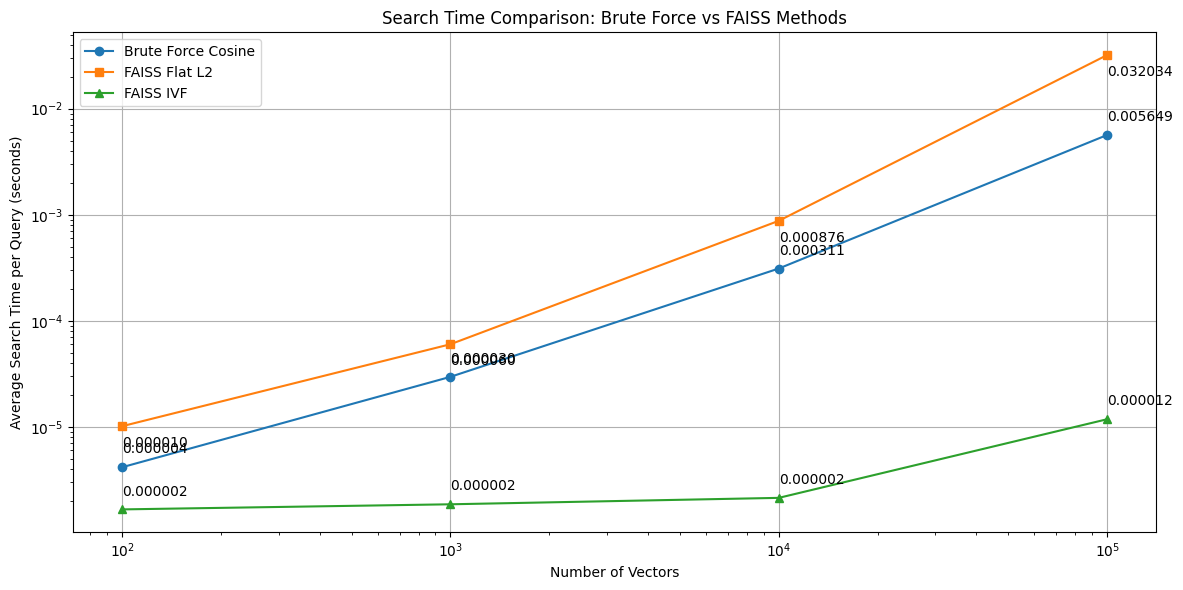

In [36]:
vector_sizes = [100, 1000, 10000, 100000]
n_queries = 1000
k = 5
dimension = 128

results = {
    'sizes': vector_sizes,
    'brute_force': [],
    'faiss_flat': [],
    'faiss_ivf': []
}

for size in vector_sizes:
    print(f"\nTesting with {size} vectors and {n_queries} queries...")
    vectors = generate_sample_vectors(size, dimension)
    query_vectors = generate_sample_vectors(n_queries, dimension)
    
    # 1. Brute Force Cosine
    start_time = time.time()
    for query in query_vectors:
        _, _ = brute_force_cosine_search(vectors, query, k)
    brute_force_time = (time.time() - start_time) / n_queries
    results['brute_force'].append(brute_force_time)
    
    # 2. FAISS Flat L2
    start_time = time.time()
    for query in query_vectors:
        _, _ = faiss_flat_l2_search(vectors, query.reshape(1, -1), k)
    faiss_flat_time = (time.time() - start_time) / n_queries
    results['faiss_flat'].append(faiss_flat_time)
    
    # 3. FAISS IVF
    n_regions = min(size // 100, 1000)
    _, search_time, _, _ = faiss_ivf_search(vectors, query_vectors, k, n_regions)
    faiss_ivf_time = search_time / n_queries
    results['faiss_ivf'].append(faiss_ivf_time)
    
    print(f"Average times per query (seconds):")
    print(f"Brute Force: {brute_force_time:.6f}")
    print(f"FAISS Flat: {faiss_flat_time:.6f}")
    print(f"FAISS IVF: {faiss_ivf_time:.6f}")

plt.figure(figsize=(12, 6))
plt.plot(results['sizes'], results['brute_force'], 'o-', label='Brute Force Cosine')
plt.plot(results['sizes'], results['faiss_flat'], 's-', label='FAISS Flat L2')
plt.plot(results['sizes'], results['faiss_ivf'], '^-', label='FAISS IVF')

plt.xscale('log')  
plt.yscale('log')  

plt.xlabel('Number of Vectors')
plt.ylabel('Average Search Time per Query (seconds)')
plt.title('Search Time Comparison: Brute Force vs FAISS Methods')
plt.grid(True)
plt.legend()

for i, size in enumerate(results['sizes']):
    plt.annotate(f'{results["brute_force"][i]:.6f}', 
                (size, results['brute_force'][i]), 
                textcoords="offset points", xytext=(0,10))
    plt.annotate(f'{results["faiss_flat"][i]:.6f}', 
                (size, results['faiss_flat'][i]), 
                textcoords="offset points", xytext=(0,-15))
    plt.annotate(f'{results["faiss_ivf"][i]:.6f}', 
                (size, results['faiss_ivf'][i]), 
                textcoords="offset points", xytext=(0,10))

plt.tight_layout()
plt.show()